# 1 - IMPORTING LIBRARIES AND DATA

In [88]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# !python -m spacy download it_core_news_sm
# !python -m spacy download pt_core_news_sm
# !python -m spacy download es_core_news_sm
# !python -m spacy download fr_core_news_sm
# !python -m spacy download ca_core_news_sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import spacy
import re
from deep_translator import GoogleTranslator
import time
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel, MarianMTModel, MarianTokenizer
from sentence_transformers import SentenceTransformer
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pickle
from google.cloud import translate_v2 as translate

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import gensim.downloader as api
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, precision_score, recall_score



nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogoparreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diogoparreira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
df_train = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
df_train_reviews = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train_reviews.xlsx")



# 2 - EXPLORATORY DATA ANALYSIS 

In [33]:
df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [34]:
df_train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [35]:
# taking 10 comments per index to reduce the size of the dataset
df_train_reviews_10 = df_train_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)

In [36]:
max_index = df_train_reviews_10["index"].max()

print(max_index)

6248


In [37]:
# making sure that all indexes have 10 comments. Some indexes were missing or had less than 10 
def ensure_ten_comments_per_index(df, max_index):
    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame(columns=df.columns)

    for idx in range(1, max_index + 1):
        # Filter the comments for the current index
        comments = df[df['index'] == idx]

        # If there are fewer than 10 comments, add empty strings
        if len(comments) < 10:
            missing_count = 10 - len(comments)
            empty_comments = pd.DataFrame({'index': [idx] * missing_count, 'comments': [''] * missing_count})
            comments = pd.concat([comments, empty_comments], ignore_index=True)

        result_df = pd.concat([result_df, comments], ignore_index=True)

    return result_df

# Apply the function to df_train_reviews
df_sampled = ensure_ten_comments_per_index(df_train_reviews_10, max_index)

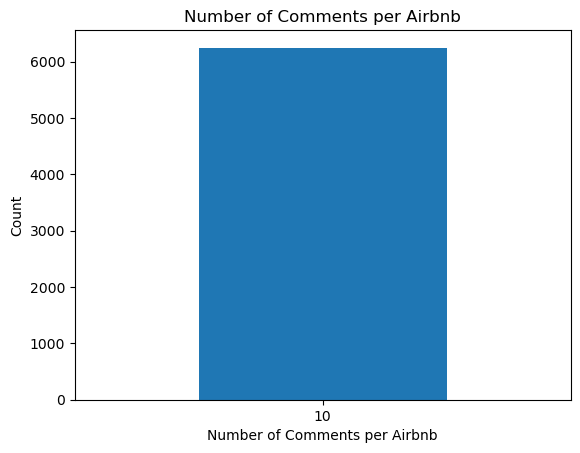

In [38]:
df_sampled['index'].value_counts().value_counts().sort_index().plot(kind='bar')
plt.title('Number of Comments per Airbnb')
plt.xlabel('Number of Comments per Airbnb')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

In [39]:
df_sampled.head()

,index,comments
0,1,Very Nice.
1,1,top
2,1,"Un lugar muy acogedor, buen lugar donde hosped..."
3,1,The property is absolutely clean and stylish. ...
4,1,"Everything is correct, like the photos said. B..."


In [40]:
# Changing the df to have an index (listing of airbnb) per row and the comments as columns
def pivot_comments(df):
    # Add a new column 'comment_num' to enumerate comments for each index
    df['comment_num'] = df.groupby('index').cumcount() + 1

    # Pivot the dataframe to create the desired format
    df_pivoted = df.pivot_table(index='index', columns='comment_num', values='comments', aggfunc='first')

    # Rename the columns to 'comment1', 'comment2', ..., 'comment10'
    df_pivoted.columns = [f'comment {i}' for i in range(1, 11)]

    # Reset the index to make 'index' a regular column
    df_pivoted.reset_index(inplace=True)

    return df_pivoted

# Call the function with your dataframe
df_pivoted = pivot_comments(df_sampled)

In [41]:
df_pivoted.head()

,index,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,Very Nice.,top,"Un lugar muy acogedor, buen lugar donde hosped...",The property is absolutely clean and stylish. ...,"Everything is correct, like the photos said. B...",Personnes très agréable et très attentionné po...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.<br/>You can fin...
1,2,,,,,,,,,,
2,3,,,,,,,,,,
3,4,,,,,,,,,,
4,5,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...,"Schöne Aussicht, sehr sauber, tolle Lage .",Lovely apartment with great views of the beach...,"Spectacular location, awsome place",Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview. ...,todo correcto. la casa está perfecta y limpia....,Clean and calm place. Perfect location - beach...,"Un super séjour,<br/>appartement conforme et c...",We really enjoyed staying at Sonias place. The...


In [42]:
#merge the description, host_about with the comments and unlisted
df_train = pd.merge(df_train, df_pivoted, on='index', how='left')
df_train.head()


,index,description,host_about,unlisted,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Very Nice.,top,"Un lugar muy acogedor, buen lugar donde hosped...",The property is absolutely clean and stylish. ...,"Everything is correct, like the photos said. B...",Personnes très agréable et très attentionné po...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.<br/>You can fin...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,,,,,,,,,,
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,,,,,,,,,,
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,,,,,,,,,,
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...,"Schöne Aussicht, sehr sauber, tolle Lage .",Lovely apartment with great views of the beach...,"Spectacular location, awsome place",Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview. ...,todo correcto. la casa está perfecta y limpia....,Clean and calm place. Perfect location - beach...,"Un super séjour,<br/>appartement conforme et c...",We really enjoyed staying at Sonias place. The...


In [43]:
# #same for test now
# df_test_reviews_10 = df_test_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)
# max_index_test = df_test_reviews["index"].max()
# df_sampled_test = ensure_ten_comments_per_index(df_test_reviews_10, max_index_test)
# df_pivoted_test = pivot_comments(df_sampled_test)
# df_test = pd.merge(df_test, df_pivoted_test, on='index', how='left')
# df_test.head()

In [44]:
# Save the dataframes as CSV files to the specified directory
# df_train.to_csv("/Users/diogoparreira/Downloads/Project Corpora/train.csv", index=False)
# df_test.to_csv("/Users/diogoparreira/Downloads/Project Corpora/test.csv", index=False)


In [45]:
#import the above csv files
#df_train = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/train.csv")
#df_test = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/test.csv")


In [46]:
# Exploration

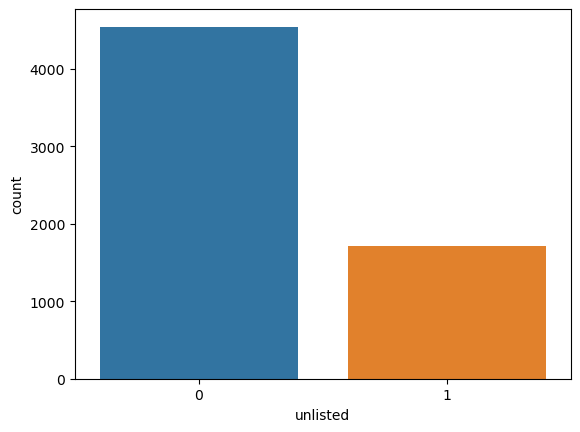

In [47]:
sns.countplot(x='unlisted', data=df_train)
plt.show()

In [48]:
# It is a bit imbalanced

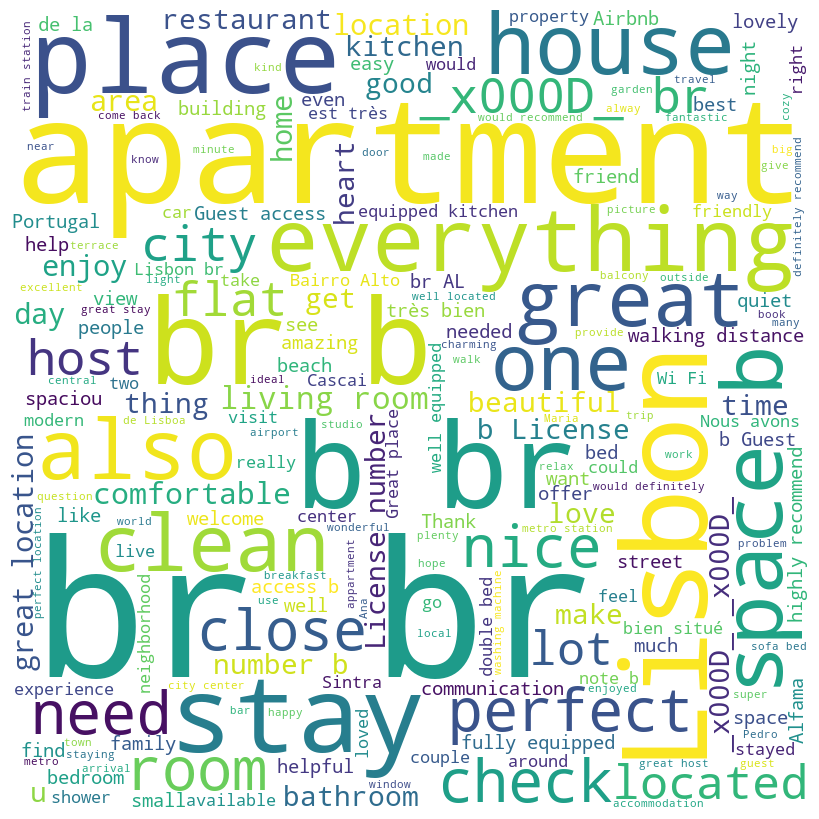

In [49]:
# word cloud for all of the df 
def create_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

# Create a single string with all comments, description, and host_about
text = ' '.join(df_train['description'].fillna('') + ' ' + df_train['host_about'].fillna('') + ' ' + df_train['comment 1'].fillna('') + ' ' + df_train['comment 2'].fillna('') + ' ' + df_train['comment 3'].fillna('') + ' ' + df_train['comment 4'].fillna('') + ' ' + df_train['comment 5'].fillna('') + ' ' + df_train['comment 6'].fillna('') + ' ' + df_train['comment 7'].fillna('') + ' ' + df_train['comment 8'].fillna('') + ' ' + df_train['comment 9'].fillna('') + ' ' + df_train['comment 10'].fillna(''))

create_wordcloud(text)



In [50]:
def clean_text(text):
    if isinstance(text, int):
        text = str(text)
    
    # Use a case-insensitive replacement for variations of x000d with 1 to 10 zeros
    text = re.sub(r'_?x0{1,10}d_?', '', text, flags=re.IGNORECASE)
    
    if '<' in text:
        clean_text = BeautifulSoup(text, "html.parser").get_text()
    else:
        clean_text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    return clean_text

def clean_dataframe(df):
    for col in df.columns:
        if col != 'index':
            df[col] = df[col].apply(clean_text)
    return df

# Clean df_train 
df_train = clean_dataframe(df_train)



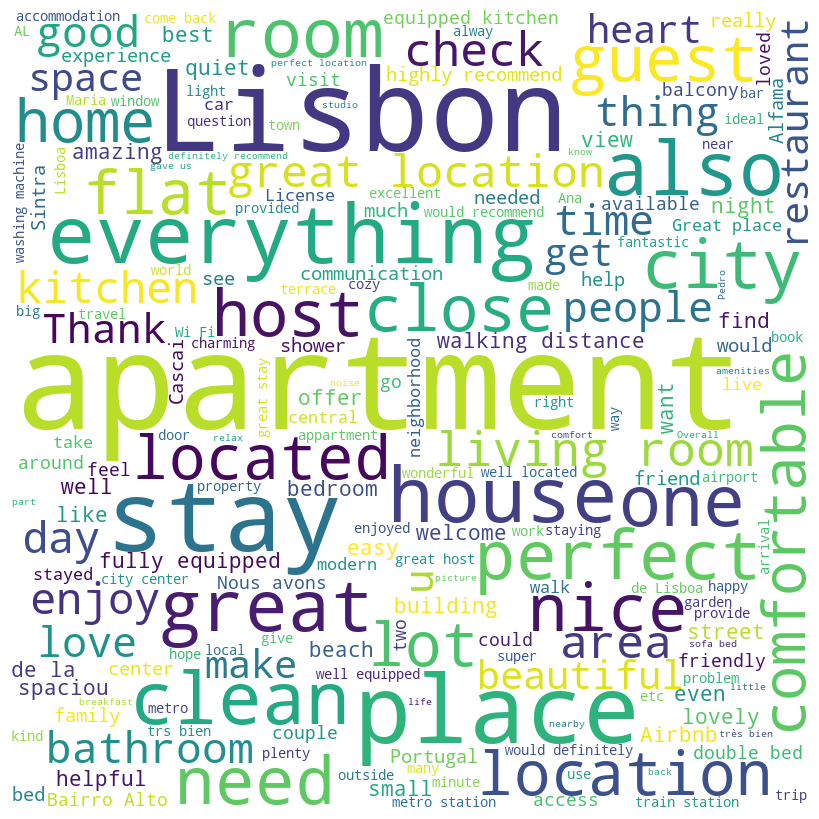

In [51]:
text = ' '.join(df_train['description'].fillna('') + ' ' + df_train['host_about'].fillna('') + ' ' + df_train['comment 1'].fillna('') + ' ' + df_train['comment 2'].fillna('') + ' ' + df_train['comment 3'].fillna('') + ' ' + df_train['comment 4'].fillna('') + ' ' + df_train['comment 5'].fillna('') + ' ' + df_train['comment 6'].fillna('') + ' ' + df_train['comment 7'].fillna('') + ' ' + df_train['comment 8'].fillna('') + ' ' + df_train['comment 9'].fillna('') + ' ' + df_train['comment 10'].fillna(''))

create_wordcloud(text)

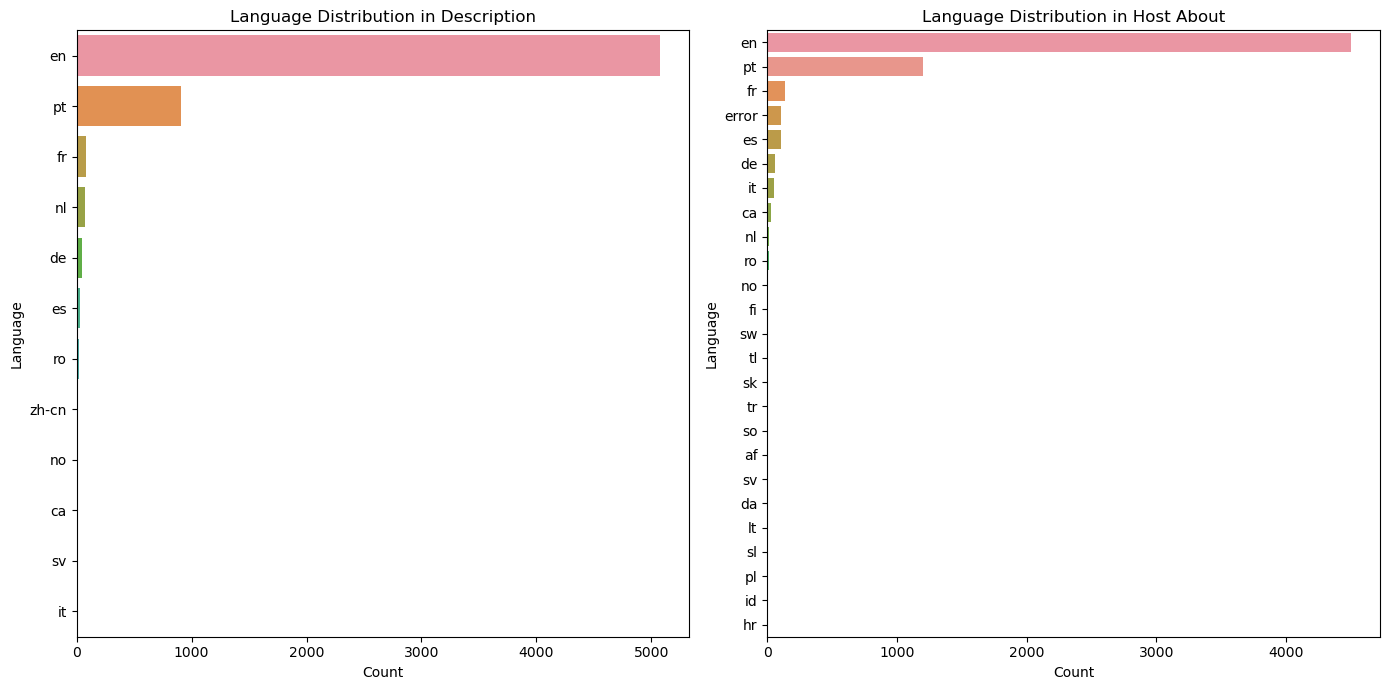

In [52]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'error'

df_train['lang_description'] = df_train['description'].apply(detect_language)
df_train['lang_host_about'] = df_train['host_about'].apply(detect_language)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(y='lang_description', data=df_train, order = df_train['lang_description'].value_counts().index)
plt.title('Language Distribution in Description')
plt.xlabel('Count')
plt.ylabel('Language')

plt.subplot(1, 2, 2)
sns.countplot(y='lang_host_about', data=df_train, order = df_train['lang_host_about'].value_counts().index)
plt.title('Language Distribution in Host About')
plt.xlabel('Count')
plt.ylabel('Language')

plt.tight_layout()
plt.show()

In [53]:
# checking for rows where language of description and host_about don't match
mismatch_mask = df_train['lang_description'] != df_train['lang_host_about']
percentage_mismatch = (mismatch_mask.sum() / len(df_train)) * 100
percentage_mismatch

23.67157490396927

In [54]:
#make a copy of the dataframe
df_train_copy = df_train.copy()


# 3 - EMBEDDINGS

## 3.1 - BERTDISTIL to embed everything wihitout translating

In [41]:
# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

def get_distilbert_embedding(text):
    if not text.strip():
        # Return a predefined vector for empty strings
        return np.zeros(model.config.hidden_size)
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Forward pass through DistilBERT model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings from DistilBERT's output
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0)
    return embeddings.numpy()

In [19]:

# Embed all descriptions
descriptions = df_train['description'].astype(str).tolist()
description_embeddings = []

# Embed descriptions with progress bar
for desc in tqdm(descriptions, desc="Embedding descriptions"):
    description_embeddings.append(get_distilbert_embedding(desc))

df_train['description_embedding'] = description_embeddings


Embedding descriptions:   0%|          | 0/6248 [00:00<?, ?it/s]

In [20]:
# Get host abouts and convert to list of strings
host_abouts = df_train['host_about'].astype(str).tolist()

# Embed host abouts with progress bar
host_about_embeddings = []
for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
    host_about_embeddings.append(get_distilbert_embedding(host_about))

# Assign host about embeddings to DataFrame
df_train['host_about_embedding'] = host_about_embeddings



Embedding host abouts:   0%|          | 0/6248 [00:00<?, ?it/s]

In [21]:
print(df_train.head())
for i in range(5):
    print(f"Embedding length for row {i+1}: {len(df_train['host_about_embedding'][i])}")


   index                                        description  \
0      1  This is a shared mixed room in our hostel with...   
1      2  O meu espao fica perto de Parque Eduardo VII S...   
2      3  Trafarias House is a cozy and familiar villa w...   
3      4  Apartamento Charmoso no Chiado Entre o Largo d...   
4      5  Joli appartement  en bordure de mer 2 min a pi...   

                                          host_about unlisted  \
0                  Alojamento Local Registro 20835AL        0   
1  I am friendly host and I will try to always be...        1   
2  I am a social person liking to communicate rea...        1   
3  Hellox000D\nI m Portuguese and i love to meet ...        0   
4  Nous sommes une famille avec deux enfants de 1...        0   

                                           comment 1  \
0                                          Very Nice   
1                                                      
2                                                      
3     

In [42]:
# Embed all comments
comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
                    'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# Initialize a dictionary to hold embeddings for each comment column
comments_embeddings = {col: [] for col in comments_columns}

In [22]:

# Embed each comment column separately with progress bar
for col in comments_columns:
    comments = df_train[col].tolist()
    for comment in tqdm(comments, desc=f"Embedding {col}"):
        if isinstance(comment, str):
            comments_embeddings[col].append(get_distilbert_embedding(comment))
        else:
            # Use a zero vector if the comment is not a string (e.g., NaN)
            comments_embeddings[col].append(np.zeros(768))

# Add embeddings back to the dataframe
for col in comments_columns:
    df_train[f'{col}_embedding'] = comments_embeddings[col]

Embedding comment 1:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 2:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 3:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 4:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 5:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 6:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 7:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 8:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 9:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 10:   0%|          | 0/6248 [00:00<?, ?it/s]

In [24]:
#divide the train into train and validation
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


In [25]:
# lets use the embedings to predict the unlisted column 
# Define the features and target variable. The features should be the embeddings
X_train = df_train[['description_embedding', 'host_about_embedding', 
                    'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                    'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                    'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                    'comment 10_embedding']]
X_val = df_val[['description_embedding', 'host_about_embedding',
                'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                'comment 10_embedding']]

y_train = df_train['unlisted']
y_val = df_val['unlisted']

# # Convert the embeddings to numpy arrays
# X_train = np.array(X_train.values.tolist())
# X_val = np.array(X_val.values.tolist())


In [26]:
X_train.shape

(4998, 12)

In [27]:
#look at the first value of the description_embedding
X_train['description_embedding'][0]

array([-2.85978168e-01, -2.56181091e-01,  2.04515249e-01, -2.79023796e-02,
        1.98387668e-01,  2.35756263e-02, -3.28062713e-01,  1.71490878e-01,
       -2.11339593e-01, -2.82241926e-02,  9.38400701e-02,  2.00517222e-01,
        8.39001298e-01,  3.44331086e-01,  1.06219716e-01, -3.91563267e-01,
        4.02772903e-01, -4.47052598e-01,  4.19721127e-01,  2.89283663e-01,
        2.83775330e-01,  2.04233795e-01,  2.25758582e-01, -1.14375390e-01,
        2.54416466e-01, -1.22701444e-01, -4.99133021e-01,  9.57736894e-02,
       -3.99195738e-02, -2.33291671e-01,  1.12832509e-01,  5.72889507e-01,
       -2.45490268e-01,  8.17805767e-01,  5.25217019e-02,  2.99819201e-01,
        1.84777379e-01,  2.96739787e-01, -1.12581670e-01, -1.86522394e-01,
       -2.90778596e-02,  3.63248438e-01,  2.86400408e-01, -2.04956725e-01,
        3.45782667e-01, -2.23039120e-01,  4.52955246e-01,  1.77736714e-01,
       -1.52998000e-01, -2.85406530e-01,  7.13064820e-02, -2.95515656e-01,
        6.76545620e-01,  

In [28]:
y_train

1738    0
142     1
2638    0
3407    1
5650    0
       ..
3772    0
5191    1
5226    0
5390    0
860     1
Name: unlisted, Length: 4998, dtype: object

In [29]:
X_train.head()

,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
1738,"[-0.20470436, -0.23839971, 0.303345, 0.1398042...","[-0.04256296, -0.15366057, -0.120283484, 0.395...","[0.09037343, -0.20292337, 0.1431247, 0.1589535...","[-0.1787788, -0.35959342, -0.04760647, 0.02264...","[0.040639155, -0.29456124, 0.28896725, 0.42972...","[-0.090141065, -0.53219813, 0.3240194, 0.46815...","[0.104196586, -0.18798164, 0.44960222, 0.31420...","[-0.18548732, -0.3183362, -0.295636, 0.2092443...","[0.03437853, -0.18645819, -0.0070517757, 0.212...","[-0.27099264, -0.523219, 0.29767436, 0.0444691...","[0.003647952, -0.32476208, 0.5379392, 0.313290...","[-0.16650839, -0.28550646, 0.36706597, 0.14799..."
142,"[0.055727407, -0.16742255, 0.35076088, 0.33966...","[-0.22538137, -0.40542316, -0.07076159, -0.146...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
2638,"[-0.18655038, -0.22335035, 0.20210643, 0.01560...","[-0.22883394, -0.0008261181, 0.10724445, -0.05...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
3407,"[-0.29429653, -0.2608666, 0.08344908, -0.08472...","[0.2201043, -0.11754492, 0.25464883, 0.1068565...","[-0.104928866, -0.5147655, 0.11046683, 0.02960...","[0.045188297, -0.37775227, -0.3434282, 0.41255...","[-0.17907572, -0.44759983, 0.2629546, -0.04663...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
5650,"[-0.45134586, -0.3250975, 0.21362151, -0.04061...","[0.1488951, -0.07589937, 0.35994726, 0.1156875...","[-0.12555537, -0.16222171, -0.075729534, 0.051...","[0.1788513, -0.08927859, 0.0065753856, 0.14931...","[-0.03907493, -0.32141218, 0.30669302, 0.16930...","[0.056224275, -0.19399175, 0.039945003, 0.2145...","[-0.029564092, -0.087317124, 0.055836074, 0.06...","[0.040635925, -0.2041511, -0.048759967, -0.035...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."


In [30]:

X_train.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
X_val.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")


In [331]:
#import the above pickle files
df_train = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
df_val = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")

df_combined = pd.concat([df_train, df_val], ignore_index=False)

# Sort the dataframe by its index to restore the original order
df_combined.sort_index(inplace=True)
df_train=df_combined
# Verify the combined dataframe
df_train

,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
0,"[-0.28597817, -0.2561811, 0.20451525, -0.02790...","[-0.023185158, -0.37697086, 0.6086536, -0.1410...","[0.21510991, -0.5110688, 0.69160336, 0.2025546...","[0.18484162, -0.56833196, 0.47783622, 0.284128...","[0.09349856, -0.63477594, -0.14457683, 0.41328...","[-0.29734465, -0.19852522, 0.17212053, 0.20468...","[-0.11321141, -0.41792384, 0.07180977, 0.35758...","[-0.0023590056, -0.10258668, -0.15480903, 0.17...","[0.1438322, -0.0015778223, 0.27991143, 0.13235...","[-0.023849774, -0.20133433, 0.050635666, 0.209...","[-0.2545836, -0.2023835, 0.70131767, -0.157883...","[0.0047822385, -0.3168874, -0.13371149, 0.0315..."
1,"[0.18437931, -0.11173112, 0.43281272, 0.089186...","[-0.15800077, -0.33181137, -0.24007031, 0.0658...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
2,"[-0.14702906, -0.23966931, 0.20506309, -0.0151...","[-0.03918232, -0.2257988, 0.08007751, 0.135921...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
3,"[0.39728495, -0.16655768, 0.46793407, 0.002151...","[0.057093, -0.3122489, 0.22554955, 0.06031866,...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
4,"[-0.08822807, -0.12400062, -0.06767958, 0.1593...","[-0.16636522, -0.16522944, -0.0675881, 0.05344...","[0.00738841, -0.16963515, 0.40382797, 0.090700...","[-0.122491114, -0.21452355, 0.2420692, 0.22980...","[-0.12166471, -0.15910466, -0.09568889, 0.0760...","[-0.17308037, -0.19063288, 0.24026674, 0.48821...","[-0.0561226, -0.3945254, 0.045986615, 0.186733...","[-0.26298475, -0.1668021, 0.085691415, 0.17763...","[-0.25435126, -0.457975, -0.060825888, 0.20592...","[-0.32600078, -0.12007493, 0.06251769, 0.07930...","[0.23901406, -0.32855862, -0.13566472, 0.13132...","[-0.040487032, -0.22121687, 0.09313486, -0.129..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[-0.11104308, -0.3303779, 0.20172907, -0.09846...","[0.14185272, -0.35670534, 0.15576531, -0.00200...","[0.23236927, -0.41243234, -0.070291676, 0.2329...","[-0.24943158, -0.3896658, -0.05980366, -0.1709...","[0.029333342, -0.1336594, -0.19647847, 0.05486...","[-0.108770266, -0.24306116, -0.11743934, 0.058...","[0.0066942764, -0.4679566, 0.13045095, 0.04144...","[-0.018899033, -0.04430035, -0.0009475003, 0.2...","[-0.14282534, -0.42925772, -0.18576789, 0.1510...","[0.108146146, -0.25060797, 0.032589085, 0.0944...","[-0.12030066, -0.21061252, -0.16211589, -0.051.

In [332]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

In [333]:
def flatten_row(row):
    return np.concatenate(row.values)

df_train_flattened = df_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)



In [334]:

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))


X_train shape: (6248, 9216)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


### 3.1.1 - Making predictions - always using the same models - rf, knn and LSTM

In [335]:
def rfe_test(X_train, y_train, num_folds=5, random_state=42):
    rf = RandomForestClassifier(random_state=random_state)
    
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    scores = cross_val_score(rf, X_train, y_train, cv=num_folds, scoring=scoring)
    
    mean_scores = {metric: np.mean(scores[:, i]) for i, metric in enumerate(scoring)}
    std_scores = {metric: np.std(scores[:, i]) for i, metric in enumerate(scoring)}
    
    print('Average scores for all folds:')
    for metric in scoring:
        print(f'> {metric.capitalize()}: {mean_scores[metric]} (+- {std_scores[metric]})')

    return scores[:, 0], scores[:, 1], scores[:, 2], scores[:, 3]




In [336]:
rfe_results = rfe_test(X_train, y_train)


Training fold 1...


Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8921272057646117 (+- 0.004853371190398198)
> Recall: 0.8284217577468669
> Precision: 0.7878643956477299
> F1-score: 0.8075340636475195


In [337]:
def knn_test(X_train, y_train, num_folds=5, n_neighbors=10, random_state=42):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    cv_results = cross_val_score(knn, X_train, y_train, cv=num_folds, scoring='accuracy')
    accuracy_per_fold = cv_results.tolist()

    cv_results = cross_val_score(knn, X_train, y_train, cv=num_folds, scoring='recall')
    recall_per_fold = cv_results.tolist()

    cv_results = cross_val_score(knn, X_train, y_train, cv=num_folds, scoring='precision')
    precision_per_fold = cv_results.tolist()

    cv_results = cross_val_score(knn, X_train, y_train, cv=num_folds, scoring='f1')
    f1_score_per_fold = cv_results.tolist()

    # Print average metrics after all folds
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
    print(f'> Recall: {np.mean(recall_per_fold)}')
    print(f'> Precision: {np.mean(precision_per_fold)}')
    print(f'> F1-score: {np.mean(f1_score_per_fold)}')

    return accuracy_per_fold, recall_per_fold, precision_per_fold, f1_score_per_fold




In [338]:
knn_results = knn_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8746820816653322 (+- 0.00908724382940878)
> Recall: 0.7653120307657348
> Precision: 0.7736759203174325
> F1-score: 0.7693921700745661


In [339]:
def lstm_test(X_train, y_train, num_folds=5, lstm_epochs=20, lstm_batch_size=32, random_state=42):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    accuracy_per_fold = []
    loss_per_fold = []
    recall_per_fold = []
    precision_per_fold = []
    f1_score_per_fold = []

    fold_no = 1
    for train_index, val_index in kf.split(X_train_lstm):
        print(f'Training fold {fold_no} for LSTM...')

        X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = Sequential([
            LSTM(100, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(f'model_fold_{fold_no}.keras', save_best_only=True, monitor='val_loss')

        history = model.fit(X_train_fold, y_train_fold, 
                            validation_data=(X_val_fold, y_val_fold), 
                            epochs=lstm_epochs, 
                            batch_size=lstm_batch_size, 
                            callbacks=[early_stopping, model_checkpoint], 
                            verbose=1)

        y_pred = model.predict(X_val_fold)
        y_pred_classes = (y_pred > 0.5).astype(int)

        report = classification_report(y_val_fold, y_pred_classes, target_names=['Class 0', 'Class 1'], output_dict=True)

        recall_per_fold.append(report['Class 1']['recall'])
        precision_per_fold.append(report['Class 1']['precision'])
        f1_score_per_fold.append(report['Class 1']['f1-score'])

        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracy_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        fold_no += 1

    print('Average scores for LSTM:')
    print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> Recall: {np.mean(recall_per_fold)}')
    print(f'> Precision: {np.mean(precision_per_fold)}')
    print(f'> F1-score: {np.mean(f1_score_per_fold)}')

    return accuracy_per_fold, loss_per_fold, recall_per_fold, precision_per_fold, f1_score_per_fold



In [340]:
lstm_results = lstm_test(X_train, y_train)


Training fold 1 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8461 - loss: 0.3910 - val_accuracy: 0.8696 - val_loss: 0.3409
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8650 - loss: 0.3601 - val_accuracy: 0.8680 - val_loss: 0.3502
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8556 - loss: 0.3618 - val_accuracy: 0.8696 - val_loss: 0.3386
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8523 - loss: 0.3698 - val_accuracy: 0.8696 - val_loss: 0.3378
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8436 - loss: 0.3741 - val_accuracy: 0.8704 - val_loss: 0.3444
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8689 - loss: 0.3513 - val_accuracy: 0.8704 - val_loss: 0.3441
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8602 - loss: 0.3731 - val_accuracy: 0.8704 - val_loss: 0.3369
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8588 - loss: 0.3566 - val_acc

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8364 - loss: 0.3823 - val_accuracy: 0.8728 - val_loss: 0.3453
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8636 - loss: 0.3533 - val_accuracy: 0.8728 - val_loss: 0.3536
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8607 - loss: 0.3557 - val_accuracy: 0.8728 - val_loss: 0.3450
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8644 - loss: 0.3604 - val_accuracy: 0.8728 - val_loss: 0.3489
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8700 - loss: 0.3433 - val_accuracy: 0.8728 - val_loss: 0.3527
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8509 - loss: 0.3626 - val_accuracy: 0.8728 - val_loss: 0.3444
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8686 - loss: 0.3322 - val_accuracy: 0.8728 - val_loss: 0.3530
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8625 - loss: 0.3506 - val_ac

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8313 - loss: 0.3916 - val_accuracy: 0.8544 - val_loss: 0.3696
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8735 - loss: 0.3473 - val_accuracy: 0.8536 - val_loss: 0.3684
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8707 - loss: 0.3439 - val_accuracy: 0.8536 - val_loss: 0.3687
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8628 - loss: 0.3568 - val_accuracy: 0.8544 - val_loss: 0.3690
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8661 - loss: 0.3521 - val_accuracy: 0.8536 - val_loss: 0.3695
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Training fold 4 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8222 - loss: 0.4056 - val_accuracy: 0.8711 - val_loss: 0.3448
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8697 - loss: 0.3526 - val_accuracy: 0.8711 - val_loss: 0.3464
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8621 - loss: 0.3648 - val_accuracy: 0.8711 - val_loss: 0.3401
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8559 - loss: 0.3564 - val_accuracy: 0.8711 - val_loss: 0.3456
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8499 - loss: 0.3651 - val_accuracy: 0.8711 - val_loss: 0.3431
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8619 - loss: 0.3608 - val_accuracy: 0.8711 - val_loss: 0.3429
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Training fold 5 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8260 - loss: 0.4002 - val_accuracy: 0.8695 - val_loss: 0.3517
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8671 - loss: 0.3539 - val_accuracy: 0.8687 - val_loss: 0.3490
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8535 - loss: 0.3677 - val_accuracy: 0.8695 - val_loss: 0.3467
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8625 - loss: 0.3498 - val_accuracy: 0.8687 - val_loss: 0.3515
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8540 - loss: 0.3680 - val_accuracy: 0.8695 - val_loss: 0.3512
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8561 - loss: 0.3623 - val_accuracy: 0.8695 - val_loss: 0.3551
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Average scores for LSTM:
> Accuracy: 0.8674784898757935 (+- 0.007023198742662074)
> Loss: 0.34731718301773074
> Recall: 0.8447872200490922
> Precision: 0.7193400703051144
> F1-score: 0.

### 3.1.2 - Do we need all the 10 comments or can we just average them? ###

In [341]:
def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

X_train = np.apply_along_axis(average_and_reduce, 1, X_train)

# Verify the shapes
print("X_train_reduced shape:", X_train.shape) 



X_train_reduced shape: (6248, 2304)


In [342]:
rfe_results = rfe_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8942077181745397 (+- 0.005903908667811564)
> Recall: 0.8294675416730855
> Precision: 0.7929407135106905
> F1-score: 0.8107111712224192


In [343]:
knn_results = knn_test(X_train, y_train)


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.860756060848679 (+- 0.007528377365484373)
> Recall: 0.7524435289432302
> Precision: 0.7418194362062864
> F1-score: 0.7469445865842299


In [344]:
lstm_results = lstm_test(X_train, y_train)

Training fold 1 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8015 - loss: 0.4104 - val_accuracy: 0.8552 - val_loss: 0.3422
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8512 - loss: 0.3587 - val_accuracy: 0.8560 - val_loss: 0.3365
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8677 - loss: 0.3387 - val_accuracy: 0.8416 - val_loss: 0.3482
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8563 - loss: 0.3553 - val_accuracy: 0.8792 - val_loss: 0.3265
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8699 - loss: 0.3297 - val_accuracy: 0.8712 - val_loss: 0.3428
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8750 - loss: 0.3177 - val_accuracy: 0.8752 - val_loss: 0.3269
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8646 - loss: 0.3442 - val_accuracy: 0.8776 - val_loss: 0.3240
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8843 - loss: 0.3003 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8180 - loss: 0.4021 - val_accuracy: 0.8600 - val_loss: 0.3553
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8619 - loss: 0.3436 - val_accuracy: 0.8680 - val_loss: 0.3398
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8635 - loss: 0.3349 - val_accuracy: 0.8656 - val_loss: 0.3506
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8718 - loss: 0.3270 - val_accuracy: 0.8704 - val_loss: 0.3422
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8755 - loss: 0.3246 - val_accuracy: 0.8728 - val_loss: 0.3328
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8736 - loss: 0.3282 - val_accuracy: 0.8696 - val_loss: 0.3369
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8833 - loss: 0.2946 - val_accuracy: 0.8752 - val_loss: 0.3298
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8888 - loss: 0.2975 - val_accuracy: 0.873

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8227 - loss: 0.3796 - val_accuracy: 0.8392 - val_loss: 0.3771
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8605 - loss: 0.3515 - val_accuracy: 0.8600 - val_loss: 0.3611
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8526 - loss: 0.3579 - val_accuracy: 0.8632 - val_loss: 0.3624
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8688 - loss: 0.3444 - val_accuracy: 0.8616 - val_loss: 0.3599
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8787 - loss: 0.3122 - val_accuracy: 0.8536 - val_loss: 0.3571
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8807 - loss: 0.3187 - val_accuracy: 0.8640 - val_loss: 0.3654
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8780 - loss: 0.3175 - val_accuracy: 0.8632 - val_loss: 0.3485
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8863 - loss: 0.2996 - val_accu

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8090 - loss: 0.3929 - val_accuracy: 0.8503 - val_loss: 0.3626
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8321 - loss: 0.3785 - val_accuracy: 0.8543 - val_loss: 0.3651
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8536 - loss: 0.3567 - val_accuracy: 0.8775 - val_loss: 0.3338
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8625 - loss: 0.3475 - val_accuracy: 0.8471 - val_loss: 0.3554
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8613 - loss: 0.3458 - val_accuracy: 0.8815 - val_loss: 0.3340
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8723 - loss: 0.3275 - val_accuracy: 0.8551 - val_loss: 0.3437
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Training fold 5 for LSTM...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8032 - loss: 0.4112 - val_accuracy: 0.8519 - val_loss: 0.3559
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8555 - loss: 0.3568 - val_accuracy: 0.8615 - val_loss: 0.3506
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8691 - loss: 0.3479 - val_accuracy: 0.8607 - val_loss: 0.3417
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8741 - loss: 0.3260 - val_accuracy: 0.8455 - val_loss: 0.3647
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8762 - loss: 0.3172 - val_accuracy: 0.8735 - val_loss: 0.3399
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8771 - loss: 0.3104 - val_accuracy: 0.8631 - val_loss: 0.3368
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8780 - loss: 0.3226 - val_accuracy: 0.8783 - val_loss: 0.3367
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8859 - loss: 0.3001 - val_accuracy: 0.858

## 3.2 - Translating eveything to EN and using different embedding techniques

In [185]:
#lets get a copy of the df_train 
df_train = df_train_copy.copy()

In [186]:
df_train 

,index,description,host_about,unlisted,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,lang_description,lang_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro 20835AL,0,Very Nice,top,Un lugar muy acogedor buen lugar donde hospeda...,The property is absolutely clean and stylish I...,"Everything is correct, like the photos said. B...",Personnes trs agrable et trs attentionn pour n...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.You can find the...,en,pt
1,2,O meu espao fica perto de Parque Eduardo VII S...,I am friendly host and I will try to always be...,1,,,,,,,,,,,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,I am a social person liking to communicate rea...,1,,,,,,,,,,,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello\nI m Portuguese and i love to meet peopl...,0,,,,,,,,,,,pt,en
4,5,Joli appartement en bordure de mer. 2 min. a ...,Nous sommes une famille avec deux enfants de 1...,0,Vista fabulosa.Bom apartamento. Localização fa...,Schne Aussicht sehr sauber tolle Lage,Lovely apartment with great views of the beach...,Spectacular location awsome place,Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview H...,todo correcto la casa est perfecta y limpia la...,Clean and calm place Perfect location beach g...,"Un super séjour,appartement conforme et confor...",We really enjoyed staying at Sonias place The ...,fr,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",Im a Brand Manager from Lisbon in Portugal but...,0,"Studio superbe, très propre et super bien équi...",We really enjoyed our stay The host location ...,Logement parfaitement adapt et bien equip trs ...,"Vasco and his wife are wonderful people, we mi...","Vasco hat uns immer sehr schnell geantwortet, ...",We had a great time in Vascos appartment every...,The host was super supportive and very nice gu...,Mes parents ont passé un excellent séjour au S...,Vasco and Anna were amazing hosts They picked...,"Ottimo host, gentile, veloce e simpatico.Centr...",en,en
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors How do we ...,0,This a spacious apartment in the heart of Barr...,This place is great Modern clean flat right in...,Airco was welkom geweest! De locatie is top!,Attention un peu froid en hiver Super vue de ...,Appartement trs bien situ et bien isol du brui...,Trs bon sjour dans le Bairro Alto lappartement...,Awesome hosts perfect communication nice flat ...,The apartment was very nice we enjoyed it,Great place to stay in Lisbon for a few days C...,I had a really good time in this flat!The host...,en,en
6245,6246,License numberExempt,I am a travel agent passionate by cultures \nI...,1,Location location location If beach vibes a lo...,"O Apartamento é bem agradável, como mencionado...",Do not recommend. Host extremely hard to commu...,Apenas a melhor estadia no Estoril !Sara é óti...,Excellent stay at Saras Everything is thorough...,Buena ubicacin y Sara muy atenta en todo momento,We spent two days in Estoril with stormy coast...,Saras place is as described and even though it...,O local fica nos fundos do que parece ser uma ...,Sara es una anfitriona genial Siempre estuvo a...,ro,en
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Famlia\nPortugal\nGavio\nmsica\npasseios,0,No pudimos disfrutar de la estancia por un pro...,I had a comfortable and easy stay here for fou...,Maria is an amazing host the entire place is s...,It’s nice and spacious room near the entrecomp...,another great stay my second with Maria conven...,Clean great location great shopping comfortable,"Ótimo lugar, próximo de duas estações de metrô...","Excelente estadia, instalações impecáveis e an...",Wir 

In [98]:
# Set Google Cloud credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/diogoparreira/Downloads/idyllic-silo-423522-f5-d45c376d14ed.json"

# Initialize Google Translate client
translate_client = translate.Client()

# Define the target language
target_language = 'en'

# Columns to translate
columns_to_translate = ['description', 'host_about', 'comment 1', 'comment 2', 'comment 3',
                        'comment 4', 'comment 5', 'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# Function to translate text using Google Translate API
def translate_text(text):
    translation = translate_client.translate(text, target_language=target_language)
    return translation['translatedText']

# Translate each column and create new DataFrame with translated columns
translated_columns = {}
for col in tqdm(columns_to_translate):
    translated_columns[col] = df_train[col].apply(lambda x: translate_text(x))

# Create DataFrame with translated columns
df_train_translated = pd.DataFrame(translated_columns)

# Save the translated DataFrame to the specified directory
output_file_path = "/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv"
df_train_translated.to_csv(output_file_path, index=False)

print(f"Translated DataFrame saved to: {output_file_path}")


100%|██████████| 12/12 [1:24:15<00:00, 421.28s/it]


Translated DataFrame saved to: /Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv


In [220]:
df_train_translated = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv") 

In [221]:
df_train_translated.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration 20835AL,Very Nice,top,"A very cozy place, good place to stay, very cl...",The property is absolutely clean and stylish I...,"Everything is correct, like the photos said. B...",Very pleasant people and very attentive to our...,You have to be there,My stay was when the Corona outbreak was start...,Great location and very good communication,Beside to big street and park.You can find the...
1,My space is close to Parque Eduardo VII Saldan...,I am friendly host and I will try to always be...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Trafaria’s House is a cozy and familiar villa ...,I am a social person liking to communicate rea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Charming Apartment in Chiado, Between Largo do...",Hellox000D\nI m Portuguese and i love to meet ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nice apartment by the sea. 2 min. walk to the ...,We are a family with two children aged 17 and ...,Fabulous view. Nice apartment. Fantastic locat...,Nice view very clean great location,Lovely apartment with great views of the beach...,Spectacular location awsome place,My boyfriend and I stayed with Sonia for a wee...,Clean Appartement with a very nice oceanview H...,"Everything is correct, the house is perfect an...",Clean and calm place Perfect location beach g...,"A great stay, apartment compliant and comforta...",We really enjoyed staying at Sonias place The ...


In [222]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, float):
        return text  # Return the original value if it's a float
    
    if isinstance(text, int):
        text = str(text)
    
    # Use a case-insensitive replacement for variations of x000d with 1 to 10 zeros
    text = re.sub(r'_?x0{1,10}d_?', '', text, flags=re.IGNORECASE)
    
    # Remove \nl and \n
    text = text.replace("\\nl", "").replace("\nl", "").replace("\n", "")
    
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)
    
    if '<' in text:
        clean_text = BeautifulSoup(text, "html.parser").get_text()
    else:
        clean_text = text
    
    return clean_text



In [223]:
df_train = df_train_translated.applymap(clean_text)


/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_38263/4241633162.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train_translated.applymap(clean_text)


In [224]:
df_train.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,This is shared mixed room in our hostel with ...,Local Accommodation Registration 20835AL,Very Nice,top,very cozy place good place to stay very clean...,The property is absolutely clean and stylish I...,Everything is correct like the photos said But...,Very pleasant people and very attentive to our...,You have to be there,My stay was when the Corona outbreak was start...,Great location and very good communication,Beside to big street and parkYou can find the ...
1,My space is close to Parque Eduardo VII Saldan...,am friendly host and will try to always be a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Trafarias House is cozy and familiar villa wh...,am social person liking to communicate readi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Charming Apartment in Chiado Between Largo do ...,HelloI Portuguese and love to meet people ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nice apartment by the sea min walk to the bea...,We are family with two children aged 17 and 1...,Fabulous view Nice apartment Fantastic locatio...,Nice view very clean great location,Lovely apartment with great views of the beach...,Spectacular location awsome place,My boyfriend and stayed with Sonia for week ...,Clean Appartement with very nice oceanview Hi...,Everything is correct the house is perfect and...,Clean and calm place Perfect location beach g...,great stay apartment compliant and comfortabl...,We really enjoyed staying at Sonias place The ...


In [225]:
df_train_w2v = df_train.copy()

## 3.2.1 - Word2Vec

In [182]:
w2v = gensim.downloader.load('word2vec-google-news-300')

emb_size = 300

#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

def df_corpus2vec(df):
    df_vec = pd.DataFrame(index=df.index, columns=df.columns)
    for col in df.columns:
        df_vec[col] = corpus2vec(df[col].tolist())
    return df_vec

# Apply the function to the DataFrame
df_train_vec = df_corpus2vec(df_train_w2v)


  0%|          | 0/6248 [00:01<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

In [183]:
#save the df to a pickle file
df_train_vec.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_train_vec.pkl")


In [257]:
# import the df_train_vec
df_train_vec = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_train_vec.pkl")



In [258]:
df_train_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...",[],"[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125..."
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...",[],[],[],[],[],[],[],[],[],[]
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...",[],[],[],[],[],[],[],[],[],[]
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...",[],[],[],[],[],[],[],[],[],[]
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[[0.15332031, -0.005004883, -0.22753906, 0.010...","[[-0.036621094, 0.014526367, 0.03515625, 0.230...","[[0.060791016, 0.14746094, -0.11376953, -0.068...","[[0.096191406, -0.028686523, -0.10839844, 0.14...","[[-0.057861328, -0.21777344, -0.1484375, 0.166...","[[0.03930664, -0.19628906, -0.10644531, -0.026...","[[0.055908203, 0.057617188, 0.015197754, 0.251...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[-0.12158203, 0.234375, 0.1484375, -0.0197753...","[[-0.11376953, -0.33398438, -0.029541016, 0.07...","[[-0.036132812, -0.11230469, 0.022827148, 0.22...","[[-0.21289062, -0.0043029785, -0.18066406, -0...."
6244,"[[-0.07910156, -0.0046691895, 0.02746582, 0.05...","[[-0.01184082, 0.079589844, 0.016845703, -0.08...","[[-0.018798828, 0.18554688, -0.06225586, -0.11...","[[-0.20703125, 0.203125, 0.041992188, -0.11572...","[[0.036376953, 0.10498047, 0.13769531, -0.1542...","[[0.44140625, 0.16699219, -0.029663086, 0.3261...","[[0.203125, -0.29101562, -0.12207031, -0.01135...","[[0.040527344, 0.0625, -0.017456055, 0.0786132...","[[0.07470703, -0.09033203, -0.055908203, 0.120...","[[0.203125, -0.29101562, -0.12207031, -0.01135...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14..."
6245,"[[-0.07861328, -0.46484375, 0.1640625, -0.3281...","[[0.17578125, 0.21289062, -0.07128906, 0.08496...","[[0.032714844, -0.096191406, 0.044189453, 0.17...","[[0.203125, -0.29101562, -0.12207031, -0.01135...","[[-0.17480469, -0.13183594, 0.15429688, 0.1826...","[[-0.12695312, 0.021972656, 0.28710938, 0.1533...","[[-0.21289062, -0.0043029785, -0.18066406, -0....","[[0.040527344, 0.0625, -0.017456055, 0.0786132...","[[0.25390625, 0.16113281, 0.033203125, 0.12304...","[[-0.20703125, 0.203125, 0.041992188, -0.11572...","[[0.032714844, -0.096191406, 0.044189453, 0.17...","[[-0.014709473, 0.10986328, 0.029052734, 0.332..."
6246,"[[0.15820312, 0.09326172, 0.075683594, 0.16308...","[[0.19042969, 0.09716797, -0.26757812, -0.0620...","[[-0.0012588501, -0.048339844, -0.28320312, 0....","[[-0.006958008, 0.047607422, -0.2890625, 0.025...","[[-0.26171875, -0.114746094, 0.16992188, 0.102...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.194

In [259]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

In [260]:
#concatenate
df_train_vec = pd.concat([df_train_vec, y_train], axis=1)

In [261]:
df_train_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...",[],"[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125...",0
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...",[],[],[],[],[],[],[],[],[],[],1
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...",[],[],[],[],[],[],[],[],[],[],1
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...",[],[],[],[],[],[],[],[],[],[],0
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14...",0


In [262]:
# Fill nas with vector of size 300 zeros
predefined_vector = np.zeros(300).tolist()
def fill_empty_cells(row):
    for col in row.index:
        if isinstance(row[col], list) and len(row[col]) == 0:
            row[col] = predefined_vector
    return row


# Apply the function to the DataFrame
df_train_vec = df_train_vec.apply(fill_empty_cells, axis=1)




In [263]:
df_train_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125...",0
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14...",0


In [264]:
#each cell in the DataFrame (except 'unlisted') contains the average vector of its list of vectors
def average_vector_list(vector_list):
    if len(vector_list) == 0:
        return np.zeros(300)  # Return zero vector if list is empty
    else:
        return np.mean(vector_list, axis=0)  # Compute mean along axis 0 (columns)

# Apply the function to each cell in the DataFrame (except 'unlisted' column)
for col in df_train_vec.columns:
    if col != 'unlisted':
        df_train_vec[col] = df_train_vec[col].apply(average_vector_list)




In [265]:
df_train_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[-0.03331876, 0.032420143, -0.01111933, 0.0933...","[-0.057434082, -0.010070801, -0.04650879, 0.00...","[0.15820312, 0.10595703, -0.18945312, 0.386718...","[-0.107910156, 0.020019531, 0.11425781, -0.084...","[-0.0586871, 0.0146771595, 0.01992708, 0.02474...","[0.04921468, 0.048583984, 0.0014177958, 0.0186...","[-0.004427592, 0.037742615, -0.017500559, 0.09...","[-0.031200062, 0.019298207, -0.051169656, 0.13...",0.0,"[0.02398827, 0.03863235, -0.01112511, 0.097244...","[0.03692627, -0.014770508, -0.020568848, 0.093...","[0.025091553, -0.0010136196, 0.0107216975, 0.1...",0
1,"[-0.034039814, 0.020395914, 0.048528034, 0.095...","[0.037837103, 0.07141113, 0.054973897, 0.09654...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,"[0.017008903, 0.050159805, 0.029609066, 0.0875...","[0.011689839, -0.018331427, 0.014723125, 0.071...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,"[0.10085927, -0.040285856, -0.03192205, 0.0698...","[0.04794108, -0.03079427, 0.09632568, 0.125789...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"[0.009817695, 0.006655693, -0.0004135132, 0.08...","[0.007467831, 0.044382207, 0.0035840203, 0.073...","[0.013999939, -0.03173828, -0.10020447, 0.1680...","[0.027880859, 0.0953125, -0.028295899, 0.12148...","[0.03417272, 0.00018625674, -0.017337965, 0.09...","[-0.060760498, -0.015220642, 0.028518677, 0.10...","[-0.036148008, 0.01461277, 0.0017107646, 0.109...","[0.006884766, -0.017480468, -0.03671875, 0.050...","[0.03851827, 0.018801583, -0.030153062, 0.0465...","[0.057529993, 0.04283878, -0.016104562, 0.0037...","[0.0626889, 0.028571777, -0.017330322, 0.07974...","[0.041696988, 0.029093523, -0.060075026, 0.108...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[0.018998647, -0.016179938, -0.022816507, 0.09...","[-0.050458502, 0.026021322, 0.061828613, 0.068...","[0.0034332275, 0.059032, -0.00079345703, 0.064...","[0.020546652, -0.045465644, -0.035466973, 0.09...","[-0.033577368, 0.0273052, 0.017982885, 0.04585...","[-0.0020914993, 0.029823199, 0.0035327233, 0.0...","[-0.016944885, 0.020153392, 0.001470219, 0.030...","[-0.02120074, 0.02999878, 0.06591797, 0.123125...","[0.0065620686, 0.011895015, 0.0065931124, 0.06...","[-0.004625397, -0.0095880125, 0.04617859, 0.03...","[-0.031257264, 0.035936628, 0.0027411324, 0.07...","[0.0015869141, 0.08970642, 0.034627277, 0.0934...",0
6244,"[0.021715911, 0.01715884, 0.008860049, 0.05143...","[0.009677086, 0.048309702, 0.01581856, 0.04624...","[0.05765438, 0.022997538, -0.024547577, 0.0609...","[0.0025838215, 0.09549967, 0.06719971, 0.08176...","[-0.026733398, 0.123942055, 0.10760498, 0.0404...","[0.073400326, 0.13210227, -0.036942914, 0.1430...","[-0.008707683, -0.04114787, -0.051364474, 0.02...","[0.011239188, -0.14561245, -0.06223842, 0.0455...","[0.008824666, -0.012578328, 0.010874431, 0.040...","[0.09342448, -0.027018229, -0.19368489, 0.1843...","[-0.0335194, 0.09589455, -0.0038285688, 0.0389...","[-0.017057631, 0.07647705, 0.036822423, 0.0775...",0
6245,"[-0.07861328, -0.46484375, 0.1640625, -0.32812...","[0.02320772, 0.0975104, -0.05753102, 0.0496682...","[0.071783155, -0.029430026, -0.01440139, 0.111...","[0.06781422, 0.028387936, -0.013061523, 0.0537...","[0.016875226, 0.068944514, 0.054819852, 0.0293...","[0.020136643, 0.037168406, 0.0048233033, 0.113...","[-0.0021197002, -0.0108350115, -0.021893343, 0...","[0.003704834, 0.06826172, -0.02647705, 0.20029...","[0.055519182, 0.033516806, -0.0551246, 0.05352...","[0.025678363, 0.020449774, -0.014875139, 0.043...","[0.05658863, -0.024792423, 0.00059940194, 0.02...","[0.04034424, 0.029958725, -0.052208845, 0.0747...",1
6246,"[-0.025349785, 0.066685036, 0.008980246, 0.080...","[0.19042969, 0.09716797, -0.26757812, -0.06201...","[-0.042808533, 0.060198102, -0.04371861, 0.129...","[-0.008261288, -0.010582419, -0.029305851, 0.0...","[-0.024114436, 0.0227134, -0.032997824, 0.0613...",

In [266]:
#replace any 0.0 in the df expect the unlisted column with the zero vector making sure it results in a numpy array dtype=float32
def replace_zero_vector(row):
    for col in row.index:
        if col != 'unlisted':
            if isinstance(row[col], float):
                row[col] = np.zeros(300)
    return row

# Apply the function to the DataFrame
df_train_vec = df_train_vec.apply(replace_zero_vector, axis=1)


In [267]:
df_train_vec.loc[1, 'comment 1']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [268]:
X_train = df_train_vec[['description', 'host_about', 
                    'comment 1', 'comment 2', 'comment 3', 
                    'comment 4', 'comment 5', 'comment 6', 
                    'comment 7', 'comment 8', 'comment 9', 
                    'comment 10']]

y_train = df_train_vec['unlisted']


In [269]:
df_train_flattened = X_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 3600)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


### 3.2.1 - Predictions 

In [ ]:
rfe_results = rfe_test(X_train, y_train)


In [270]:
knn_results = knn_test(X_train, y_train)


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8726001601281025 (+- 0.004732550190380146)
> Recall: 0.799433055449086
> Precision: 0.7503777270459817
> F1-score: 0.7740848806106546


In [ ]:
lstm_results = lstm_test(X_train, y_train)


### We will try the same and see if merging the 10 comments into one will improve the model or not 

In [271]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train, embedding_size=300)

In [281]:
rfe_results = rfe_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8908459247397917 (+- 0.002857562439896704)
> Recall: 0.8237059577881386
> Precision: 0.7869135188040927
> F1-score: 0.8047665244822986


In [280]:
knn_results = knn_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8497117053642915 (+- 0.006609091546707632)
> Recall: 0.7690254591192841
> Precision: 0.707019597171117
> F1-score: 0.7365603555337208


In [282]:
lstm_results = lstm_test(X_train, y_train)


Training fold 1 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7711 - loss: 0.4678 - val_accuracy: 0.8400 - val_loss: 0.3605
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8509 - loss: 0.3663 - val_accuracy: 0.8456 - val_loss: 0.3518
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8683 - loss: 0.3270 - val_accuracy: 0.8560 - val_loss: 0.3503
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8648 - loss: 0.3451 - val_accuracy: 0.8568 - val_loss: 0.3480
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8773 - loss: 0.3259 - val_accuracy: 0.8696 - val_loss: 0.3401
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8786 - loss: 0.3207 - val_accuracy: 0.8784 - val_loss: 0.3370
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8796 - loss: 0.3151 - val_accuracy: 0.8768 - val_loss: 0.3337
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8899 - loss: 0.3019 - val_accuracy: 

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7703 - loss: 0.4576 - val_accuracy: 0.8664 - val_loss: 0.3593
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8531 - loss: 0.3554 - val_accuracy: 0.8680 - val_loss: 0.3534
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8688 - loss: 0.3351 - val_accuracy: 0.8696 - val_loss: 0.3465
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8664 - loss: 0.3392 - val_accuracy: 0.8640 - val_loss: 0.3451
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8720 - loss: 0.3332 - val_accuracy: 0.8760 - val_loss: 0.3443
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8713 - loss: 0.3360 - val_accuracy: 0.8744 - val_loss: 0.3371
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8783 - loss: 0.3174 - val_accuracy: 0.8608 - val_loss: 0.3557
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8824 - loss: 0.3069 - val_accuracy: 0.8768 - val

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7602 - loss: 0.4691 - val_accuracy: 0.8400 - val_loss: 0.3752
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8543 - loss: 0.3577 - val_accuracy: 0.8424 - val_loss: 0.3744
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8641 - loss: 0.3404 - val_accuracy: 0.8560 - val_loss: 0.3654
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8704 - loss: 0.3308 - val_accuracy: 0.8624 - val_loss: 0.3627
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8693 - loss: 0.3350 - val_accuracy: 0.8560 - val_loss: 0.3620
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8770 - loss: 0.3186 - val_accuracy: 0.8600 - val_loss: 0.3557
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8842 - loss: 0.3141 - val_accuracy: 0.8624 - val_loss: 0.3636
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.2986 - val_accuracy: 0.

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7464 - loss: 0.4778 - val_accuracy: 0.8583 - val_loss: 0.3524
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8494 - loss: 0.3556 - val_accuracy: 0.8551 - val_loss: 0.3514
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8563 - loss: 0.3474 - val_accuracy: 0.8687 - val_loss: 0.3410
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8574 - loss: 0.3472 - val_accuracy: 0.8823 - val_loss: 0.3372
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8647 - loss: 0.3494 - val_accuracy: 0.8679 - val_loss: 0.3456
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8700 - loss: 0.3385 - val_accuracy: 0.8783 - val_loss: 0.3328
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8769 - loss: 0.3151 - val_accuracy: 0.8791 - val_loss: 0.3298
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8876 - loss: 0.3027 - val_accuracy: 0.8735 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7637 - loss: 0.4675 - val_accuracy: 0.8615 - val_loss: 0.3668
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8572 - loss: 0.3682 - val_accuracy: 0.8439 - val_loss: 0.3656
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8555 - loss: 0.3525 - val_accuracy: 0.8671 - val_loss: 0.3569
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8664 - loss: 0.3410 - val_accuracy: 0.8623 - val_loss: 0.3503
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8696 - loss: 0.3357 - val_accuracy: 0.8631 - val_loss: 0.3502
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8745 - loss: 0.3271 - val_accuracy: 0.8679 - val_loss: 0.3479
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8794 - loss: 0.3144 - val_accuracy: 0.8735 - val_loss: 0.3451
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8840 - loss: 0.3032 - val_accuracy: 0.

## 3.3 We will now try TF-IDF with the translated

In [287]:
# import /Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv 
df_train = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv")


In [288]:
df_train = df_train.applymap(clean_text)

/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_38263/3137519247.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train.applymap(clean_text)


In [289]:
df_train 

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,This is shared mixed room in our hostel with ...,Local Accommodation Registration 20835AL,Very Nice,top,very cozy place good place to stay very clean...,The property is absolutely clean and stylish I...,Everything is correct like the photos said But...,Very pleasant people and very attentive to our...,You have to be there,My stay was when the Corona outbreak was start...,Great location and very good communication,Beside to big street and parkYou can find the ...
1,My space is close to Parque Eduardo VII Saldan...,am friendly host and will try to always be a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Trafarias House is cozy and familiar villa wh...,am social person liking to communicate readi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Charming Apartment in Chiado Between Largo do ...,HelloI Portuguese and love to meet people ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nice apartment by the sea min walk to the bea...,We are family with two children aged 17 and 1...,Fabulous view Nice apartment Fantastic locatio...,Nice view very clean great location,Lovely apartment with great views of the beach...,Spectacular location awsome place,My boyfriend and stayed with Sonia for week ...,Clean Appartement with very nice oceanview Hi...,Everything is correct the house is perfect and...,Clean and calm place Perfect location beach g...,great stay apartment compliant and comfortabl...,We really enjoyed staying at Sonias place The ...
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,Studio 15 is new very well decorated and cozy...,Im Brand Manager from Lisbon in Portugal but ...,Superb studio very clean and super well equipp...,We really enjoyed our stay The host location ...,Perfectly adapted and wellequipped accommodati...,Vasco and his wife are wonderful people we mis...,Vasco always responded very quickly gave us lo...,We had great time in Vascos appartment everyt...,The host was super supportive and very nice gu...,My parents had great stay at Studio15 in Lisb...,Vasco and Anna were amazing hosts They picked...,Excellent host kind fast and friendly Very cen...
6244,Lisbon meets cosmopolitan industrial onebedro...,Home is where feelings are visitors How do we ...,This spacious apartment in the heart of Barri...,This place is great Modern clean flat right in...,Air conditioning would have been welcome The l...,Be careful little cold in winter Great view f...,Apartment very well located and well isolated ...,Very good stay in Bairro Alto the apartment is...,Awesome hosts perfect communication nice flat ...,The apartment was very nice we enjoyed it,Great place to stay in Lisbon for few days Ch...,had really good time in this flatThe host is...
6245,License numberExempt,am travel agent passionate by cultures welc...,Location location location If beach vibes loo...,The Apartment is very pleasant as mentioned in...,Do not recommend Host extremely hard to commun...,Just the best stay in Estoril Sara is great h...,Excellent stay at Saras Everything is thorough...,Good location and Sara very attentive at all t...,We spent two days in Estoril with stormy coast...,Saras place is as described and even though it...,The location is at the back of what appears to...,Sara is great host She was always attentive t...
6246,Campo Pequeno Prestige is classy and top qual...,Family Portugal Gavio music tours,We couldn39t enjoy the stay due to problem Bu...,had comfortable and easy stay here for four ...,Maria is an amazing host the entire place is s...,Its nice and spacious room near the entrecompo...,another great stay my second with Maria conven...,Clean great location great shopping comfortable,Great place close to two subway stations baker...,Excellent stay impeccable facilities and very ...,We had very good time in the apartment You sh...,Close to metro The place is very clean and tid...


In [290]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']
df_train = pd.concat([df_train, y_train], axis=1)


In [291]:
df_train

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,This is shared mixed room in our hostel with ...,Local Accommodation Registration 20835AL,Very Nice,top,very cozy place good place to stay very clean...,The property is absolutely clean and stylish I...,Everything is correct like the photos said But...,Very pleasant people and very attentive to our...,You have to be there,My stay was when the Corona outbreak was start...,Great location and very good communication,Beside to big street and parkYou can find the ...,0
1,My space is close to Parque Eduardo VII Saldan...,am friendly host and will try to always be a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Trafarias House is cozy and familiar villa wh...,am social person liking to communicate readi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Charming Apartment in Chiado Between Largo do ...,HelloI Portuguese and love to meet people ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Nice apartment by the sea min walk to the bea...,We are family with two children aged 17 and 1...,Fabulous view Nice apartment Fantastic locatio...,Nice view very clean great location,Lovely apartment with great views of the beach...,Spectacular location awsome place,My boyfriend and stayed with Sonia for week ...,Clean Appartement with very nice oceanview Hi...,Everything is correct the house is perfect and...,Clean and calm place Perfect location beach g...,great stay apartment compliant and comfortabl...,We really enjoyed staying at Sonias place The ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,Studio 15 is new very well decorated and cozy...,Im Brand Manager from Lisbon in Portugal but ...,Superb studio very clean and super well equipp...,We really enjoyed our stay The host location ...,Perfectly adapted and wellequipped accommodati...,Vasco and his wife are wonderful people we mis...,Vasco always responded very quickly gave us lo...,We had great time in Vascos appartment everyt...,The host was super supportive and very nice gu...,My parents had great stay at Studio15 in Lisb...,Vasco and Anna were amazing hosts They picked...,Excellent host kind fast and friendly Very cen...,0
6244,Lisbon meets cosmopolitan industrial onebedro...,Home is where feelings are visitors How do we ...,This spacious apartment in the heart of Barri...,This place is great Modern clean flat right in...,Air conditioning would have been welcome The l...,Be careful little cold in winter Great view f...,Apartment very well located and well isolated ...,Very good stay in Bairro Alto the apartment is...,Awesome hosts perfect communication nice flat ...,The apartment was very nice we enjoyed it,Great place to stay in Lisbon for few days Ch...,had really good time in this flatThe host is...,0
6245,License numberExempt,am travel agent passionate by cultures welc...,Location location location If beach vibes loo...,The Apartment is very pleasant as mentioned in...,Do not recommend Host extremely hard to commun...,Just the best stay in Estoril Sara is great h...,Excellent stay at Saras Everything is thorough...,Good location and Sara very attentive at all t...,We spent two days in Estoril with stormy coast...,Saras place is as described and even though it...,The location is at the back of what appears to...,Sara is great host She was always attentive t...,1
6246,Campo Pequeno Prestige is classy and top qual...,Family Portugal Gavio music tours,We couldn39t enjoy the stay due to problem Bu...,had comfortable and easy stay here for four ...,Maria is an amazing host the entire place is s...,Its nice and spacious room near the entrecompo...,another great stay my second with Maria conven...,Clean great location great shopping comfortable,Great place close to two subway stations baker...,Excellent stay impeccable facilities and very ...,We had very good time in the apartment You sh...,Close to metro The place is very clean and tid...

In [292]:
df = df_train.copy()

In [293]:
text_columns = [
    'description', 'host_about', 'comment 1', 'comment 2', 'comment 3', 'comment 4', 
    'comment 5', 'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10'
]
df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)




In [294]:
X = df['combined_text']
y = df['unlisted']

In [295]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [296]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000000, stop_words='english')


In [297]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)


In [298]:
print(X_train.shape)  
print(X_val.shape)  


(4998, 45666)
(1250, 45666)


In [299]:
# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8688


In [300]:
cm = confusion_matrix(y_val, y_pred)


In [301]:
print(cm)

[[826  79]
 [ 85 260]]


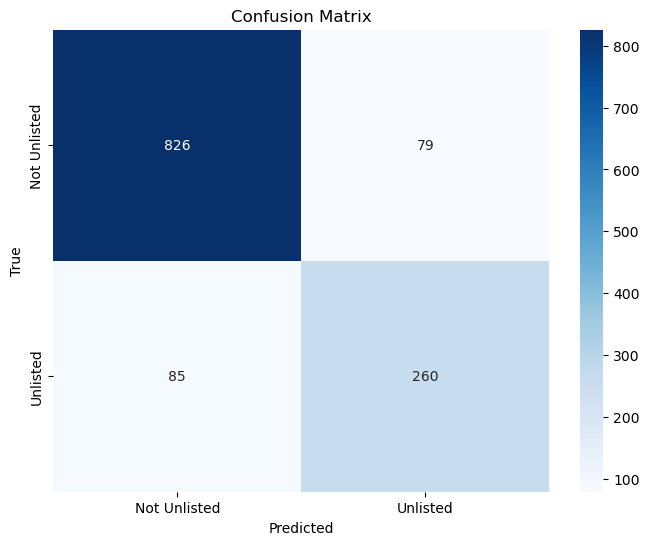

In [302]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Unlisted', 'Unlisted'], yticklabels=['Not Unlisted', 'Unlisted'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [304]:
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Average cross-validation score on training data: ", np.mean(cv_scores))

# Train the model on the full training set
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)

Average cross-validation score on training data:  0.8751499499499499
Validation accuracy:  0.8872


In [305]:
# Define the model with some chosen hyperparameters
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the average accuracy across all folds
print("Average cross-validation score: ", np.mean(scores))

knn.fit(X_train, y_train)

val_predictions = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation accuracy: ", val_accuracy)


Average cross-validation score:  0.7927187187187188
Validation accuracy:  0.8096


In [ ]:
# Won't be using NN here because it doesnt do well with the spare data

## 3.4 - Using GLOVE instead of word2vec but all will be the same 


In [326]:
#import df 
df = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv")

In [327]:
df = df.applymap(clean_text)

/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_79552/2197956661.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)
/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_79552/1433993042.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [328]:
df = pd.concat([df, df_train_copy['unlisted']], axis=1)
#replace nan with empty string
df = df.fillna('')
df['unlisted'] = df['unlisted'].astype(int)


In [331]:

glove = api.load('glove-wiki-gigaword-300')

emb_size = 300

# Function to get embeddings for each word based on GloVe model
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        # Ensure the document is a string
        if not isinstance(document, str):
            document = ''
        # Get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in glove.key_to_index:
                doc_vectors.append(glove.get_vector(word))
        corpus_vec.append(doc_vectors)
    return corpus_vec

def df_corpus2vec(df, exclude_columns=[]):
    df_vec = pd.DataFrame(index=df.index, columns=df.columns)
    for col in df.columns:
        if col not in exclude_columns:
            # Ensure all entries are strings and fill NaN values
            df[col] = df[col].fillna('').astype(str)
            df_vec[col] = corpus2vec(df[col].tolist())
        else:
            df_vec[col] = df[col]
    return df_vec

# Apply the function to the DataFrame, excluding the "unlisted" column
df_glove_vec = df_corpus2vec(df, exclude_columns=['unlisted'])

# Save the DataFrame to a pickle file
df_glove_vec.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_glove_vec.pkl")


  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

In [306]:
#import the above pickle file
df_glove_vec = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_glove_vec.pkl")

In [307]:
df_glove_vec = df_glove_vec.apply(fill_empty_cells, axis=1)


In [308]:
df_glove_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.39364, 0.44549, 0.095354, -0.56394, -0.08...","[[-0.34413, 0.37822, 0.35644, -0.062996, 0.290...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[0.13874, 0.70128, -0.053805, -0.40267, -0.00...","[[-0.29934, 0.30112, -0.28977, -0.1366, -0.416...","[[0.19596, 0.13208, -0.30807, 0.25545, -0.1265...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[-1.0572, -0.56766, 0.068961, -0.16285, -0.29...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.11001, -0.065944, -0.36711, 0.30169, 0.376...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[-0.31801, 0.20879, -0.035642, -0.16209, -0.4...",0
1,"[[0.25443, -0.22324, 0.012081, -0.49354, -0.16...","[[-0.38923, 0.32972, -0.097624, -0.57717, 0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[[-0.3707, -0.081209, -0.44626, 0.097395, 0.19...","[[-0.67916, -0.12207, -0.22908, 0.34682, 0.308...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[[-0.11905, -0.39071, 0.076198, -0.42436, 0.24...","[[-0.019703, -0.068198, -0.52512, 0.49465, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.38547, 0.59784, 0.16526, -0.28517, 0.3189...","[[0.29731, 0.13388, 0.043151, 0.25688, 0.3564,...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.63411, -0.50571, -0.36741, -0.12871, -0.2...","[[0.62462, 0.29682, 0.11151, -0.039201, -0.055...","[[-0.39638, 0.017982, -0.13137, 0.098925, 0.06...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[0.076563, 0.032454, -0.030982, -0.018969, 0....",0


In [309]:
for col in df_glove_vec.columns:
    if col != 'unlisted':
        df_glove_vec[col] = df_glove_vec[col].apply(average_vector_list)

In [310]:
df_glove_vec = df_glove_vec.apply(replace_zero_vector, axis=1)


In [321]:
df_glove_vec["comment 3"][5].shape

(300,)

In [322]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

X_train = df_glove_vec[['description', 'host_about', 
                    'comment 1', 'comment 2', 'comment 3', 
                    'comment 4', 'comment 5', 'comment 6', 
                    'comment 7', 'comment 8', 'comment 9', 
                    'comment 10']]

df_train_flattened = X_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 3600)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [323]:
rfe_results = rfe_test(X_train, y_train)


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.888445284227382 (+- 0.00294001769778118)
> Recall: 0.8173098053789163
> Precision: 0.7838870326635746
> F1-score: 0.8000926594660497


In [324]:
knn_results = knn_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8697201601281025 (+- 0.0060633715659585835)
> Recall: 0.7790923418807454
> Precision: 0.7525889348438134
> F1-score: 0.7655502995427985


In [326]:
lstm_results = lstm_test(X_train, y_train)

Training fold 1 for LSTM...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.8034 - loss: 0.3919 - val_accuracy: 0.8752 - val_loss: 0.3356
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8697 - loss: 0.3262 - val_accuracy: 0.8744 - val_loss: 0.3321
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8755 - loss: 0.3126 - val_accuracy: 0.8792 - val_loss: 0.3382
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8844 - loss: 0.2898 - val_accuracy: 0.8792 - val_loss: 0.3412
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8877 - loss: 0.2647 - val_accuracy: 0.8808 - val_loss: 0.3411
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Training fold 2 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8322 - loss: 0.3810 - val_accuracy: 0.8728 - val_loss: 0.3460
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8758 - loss: 0.3245 - val_accuracy: 0.8752 - val_loss: 0.3466
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8836 - loss: 0.3087 - val_accuracy: 0.8760 - val_loss: 0.3471
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8886 - loss: 0.2878 - val_accuracy: 0.8784 - val_loss: 0.3507
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Training fold 3 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8207 - loss: 0.3704 - val_accuracy: 0.8536 - val_loss: 0.3628
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8701 - loss: 0.3259 - val_accuracy: 0.8640 - val_loss: 0.3547
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8761 - loss: 0.3114 - val_accuracy: 0.8664 - val_loss: 0.3536
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8821 - loss: 0.2866 - val_accuracy: 0.8720 - val_loss: 0.3474
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8945 - loss: 0.2644 - val_accuracy: 0.8648 - val_loss: 0.3747
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8976 - loss: 0.2427 - val_accuracy: 0.8720 - val_loss: 0.3496
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9029 - loss: 0.2317 - val_accuracy: 0.8752 - val_loss: 0.3727
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Training fold 4 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8140 - loss: 0.3816 - val_accuracy: 0.8695 - val_loss: 0.3292
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8774 - loss: 0.3206 - val_accuracy: 0.8799 - val_loss: 0.3260
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8741 - loss: 0.3143 - val_accuracy: 0.8799 - val_loss: 0.3350
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8866 - loss: 0.2819 - val_accuracy: 0.8831 - val_loss: 0.3306
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8915 - loss: 0.2613 - val_accuracy: 0.8767 - val_loss: 0.3571
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Training fold 5 for LSTM...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8161 - loss: 0.3856 - val_accuracy: 0.8735 - val_loss: 0.3453
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8748 - loss: 0.3268 - val_accuracy: 0.8743 - val_loss: 0.3374
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8782 - loss: 0.3150 - val_accuracy: 0.8767 - val_loss: 0.3450
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8852 - loss: 0.2882 - val_accuracy: 0.8791 - val_loss: 0.3407
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8902 - loss: 0.2701 - val_accuracy: 0.8815 - val_loss: 0.3558
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Average scores for LSTM:
> Accuracy: 0.8746806740760803 (+- 0.002765118264557752)
> Loss: 0.3377782881259918
> Recall: 0.83765997299503
> Precision: 0.7388390260898479
> F1-score: 0.7849662939339148


In [327]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train, embedding_size=300)

In [328]:
rfe_results = rfe_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.889565028022418 (+- 0.0041630428102742345)
> Recall: 0.8193596169677066
> Precision: 0.7855078808046632
> F1-score: 0.8019793508824777


In [329]:
knn_results = knn_test(X_train, y_train)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average scores for all folds:
> Accuracy: 0.8519534987990391 (+- 0.0063194746240693616)
> Recall: 0.771373068010743
> Precision: 0.7114066105816184
> F1-score: 0.7400488227711787


In [330]:
lstm_results = lstm_test(X_train, y_train)

Training fold 1 for LSTM...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 508ms/step - accuracy: 0.7729 - loss: 0.4464 - val_accuracy: 0.8672 - val_loss: 0.3538
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8632 - loss: 0.3413 - val_accuracy: 0.8400 - val_loss: 0.3567
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8616 - loss: 0.3412 - val_accuracy: 0.8520 - val_loss: 0.3480
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8764 - loss: 0.3323 - val_accuracy: 0.8744 - val_loss: 0.3335
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8877 - loss: 0.3054 - val_accuracy: 0.8752 - val_loss: 0.3345
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8837 - loss: 0.3003 - val_accuracy: 0.8776 - val_loss: 0.3282
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8796 - loss: 0.3083 - val_accuracy: 0.8760 - val_loss: 0.3327
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8854 - loss: 0.2951 - val_accuracy: 0.8752 - v

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7751 - loss: 0.4459 - val_accuracy: 0.8664 - val_loss: 0.3528
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8627 - loss: 0.3384 - val_accuracy: 0.8696 - val_loss: 0.3480
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8738 - loss: 0.3411 - val_accuracy: 0.8752 - val_loss: 0.3488
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8760 - loss: 0.3277 - val_accuracy: 0.8784 - val_loss: 0.3371
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8719 - loss: 0.3235 - val_accuracy: 0.8808 - val_loss: 0.3322
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8829 - loss: 0.3029 - val_accuracy: 0.8736 - val_loss: 0.3302
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8923 - loss: 0.2857 - val_accuracy: 0.8792 - val_loss: 0.3334
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8955 - loss: 0.2783 - val_accuracy: 0

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7766 - loss: 0.4422 - val_accuracy: 0.8288 - val_loss: 0.3796
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8548 - loss: 0.3594 - val_accuracy: 0.8368 - val_loss: 0.3696
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8656 - loss: 0.3367 - val_accuracy: 0.8600 - val_loss: 0.3553
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8709 - loss: 0.3375 - val_accuracy: 0.8632 - val_loss: 0.3538
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8869 - loss: 0.3026 - val_accuracy: 0.8568 - val_loss: 0.3571
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8853 - loss: 0.3047 - val_accuracy: 0.8688 - val_loss: 0.3495
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8946 - loss: 0.2741 - val_accuracy: 0.8680 - val_loss: 0.3439
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8949 - loss: 0.2886 - val_accuracy: 0.

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7783 - loss: 0.4511 - val_accuracy: 0.8591 - val_loss: 0.3492
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8613 - loss: 0.3455 - val_accuracy: 0.8751 - val_loss: 0.3470
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8751 - loss: 0.3250 - val_accuracy: 0.8743 - val_loss: 0.3383
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8666 - loss: 0.3364 - val_accuracy: 0.8767 - val_loss: 0.3339
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8714 - loss: 0.3292 - val_accuracy: 0.8791 - val_loss: 0.3334
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8773 - loss: 0.3151 - val_accuracy: 0.8775 - val_loss: 0.3356
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8866 - loss: 0.3033 - val_accuracy: 0.8775 - val_loss: 0.3395
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8906 - loss: 0.2910 - val_accuracy: 0.

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7770 - loss: 0.4435 - val_accuracy: 0.8631 - val_loss: 0.3641
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8644 - loss: 0.3401 - val_accuracy: 0.8599 - val_loss: 0.3499
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8676 - loss: 0.3376 - val_accuracy: 0.8735 - val_loss: 0.3454
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8692 - loss: 0.3305 - val_accuracy: 0.8727 - val_loss: 0.3412
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8841 - loss: 0.3136 - val_accuracy: 0.8687 - val_loss: 0.3398
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8823 - loss: 0.3117 - val_accuracy: 0.8655 - val_loss: 0.3394
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8921 - loss: 0.2888 - val_accuracy: 0.8727 - val_loss: 0.3430
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8913 - loss: 0.2851 - val_accuracy: 0.

# final conclusion 

In [369]:
df_train = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
df_val = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")

df_combined = pd.concat([df_train, df_val], ignore_index=False)

df_combined.sort_index(inplace=True)
df_train=df_combined

df_train


,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
0,"[-0.28597817, -0.2561811, 0.20451525, -0.02790...","[-0.023185158, -0.37697086, 0.6086536, -0.1410...","[0.21510991, -0.5110688, 0.69160336, 0.2025546...","[0.18484162, -0.56833196, 0.47783622, 0.284128...","[0.09349856, -0.63477594, -0.14457683, 0.41328...","[-0.29734465, -0.19852522, 0.17212053, 0.20468...","[-0.11321141, -0.41792384, 0.07180977, 0.35758...","[-0.0023590056, -0.10258668, -0.15480903, 0.17...","[0.1438322, -0.0015778223, 0.27991143, 0.13235...","[-0.023849774, -0.20133433, 0.050635666, 0.209...","[-0.2545836, -0.2023835, 0.70131767, -0.157883...","[0.0047822385, -0.3168874, -0.13371149, 0.0315..."
1,"[0.18437931, -0.11173112, 0.43281272, 0.089186...","[-0.15800077, -0.33181137, -0.24007031, 0.0658...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
2,"[-0.14702906, -0.23966931, 0.20506309, -0.0151...","[-0.03918232, -0.2257988, 0.08007751, 0.135921...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
3,"[0.39728495, -0.16655768, 0.46793407, 0.002151...","[0.057093, -0.3122489, 0.22554955, 0.06031866,...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581...","[0.18880898, -0.04622847, 0.77542657, 0.228581..."
4,"[-0.08822807, -0.12400062, -0.06767958, 0.1593...","[-0.16636522, -0.16522944, -0.0675881, 0.05344...","[0.00738841, -0.16963515, 0.40382797, 0.090700...","[-0.122491114, -0.21452355, 0.2420692, 0.22980...","[-0.12166471, -0.15910466, -0.09568889, 0.0760...","[-0.17308037, -0.19063288, 0.24026674, 0.48821...","[-0.0561226, -0.3945254, 0.045986615, 0.186733...","[-0.26298475, -0.1668021, 0.085691415, 0.17763...","[-0.25435126, -0.457975, -0.060825888, 0.20592...","[-0.32600078, -0.12007493, 0.06251769, 0.07930...","[0.23901406, -0.32855862, -0.13566472, 0.13132...","[-0.040487032, -0.22121687, 0.09313486, -0.129..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[-0.11104308, -0.3303779, 0.20172907, -0.09846...","[0.14185272, -0.35670534, 0.15576531, -0.00200...","[0.23236927, -0.41243234, -0.070291676, 0.2329...","[-0.24943158, -0.3896658, -0.05980366, -0.1709...","[0.029333342, -0.1336594, -0.19647847, 0.05486...","[-0.108770266, -0.24306116, -0.11743934, 0.058...","[0.0066942764, -0.4679566, 0.13045095, 0.04144...","[-0.018899033, -0.04430035, -0.0009475003, 0.2...","[-0.14282534, -0.42925772, -0.18576789, 0.1510...","[0.108146146, -0.25060797, 0.032589085, 0.0944...","[-0.12030066, -0.21061252, -0.16211589, -0.051.

In [370]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

df_train_flattened = df_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 9216)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [371]:
# the model that perfomed better was the embedding with BERT and using an average of the comments and rf. 



In [372]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train)

print("X_train_reduced shape:", X_train.shape) 



X_train_reduced shape: (6248, 2304)


In [373]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 2304)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [374]:
full_training = X_train.copy()
full_target = y_train.copy()

In [375]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 2: Define the Model
rf = RandomForestClassifier(random_state=42)

# Step 3: Define the Parameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'class_weight': [None, 'balanced'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2], 
    'max_depth': [10, 20]
}

# Step 4: Set up the Scorer
f1_scorer = make_scorer(f1_score)

# Step 5: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Step 6: Fit the GridSearchCV to the Training Data
grid_search.fit(X_train, y_train)

# Step 7: Print the Best Parameters and Best Score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: ", grid_search.best_score_)

# Step 8: Train the Model with the Best Parameters on the Full Training Set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Step 9: Perform Prediction on the Validation Set (Optional)
val_predictions = best_rf.predict(X_val)

# Step 10: Evaluate the Model (Optional)
val_f1_score = f1_score(y_val, val_predictions)
print("Validation F1 score: ", val_f1_score)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


python(31669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(31671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  35.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  35.8s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  35.8s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  35.8s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  35.8s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  31.7s
[CV] END class_weight=None, max_depth=10

In [395]:
#lets import the test data /Users/diogoparreira/Downloads/Project Corpora/test_reviews.xlsx
df_test = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/test.xlsx")

#and test reviews 
df_test_reviews = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/test_reviews.xlsx")




In [396]:
df_test_reviews_10 = df_test_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)
max_index_test = df_test_reviews["index"].max()
df_sampled_test = ensure_ten_comments_per_index(df_test_reviews_10, max_index_test)
df_pivoted_test = pivot_comments(df_sampled_test)
df_test = pd.merge(df_test, df_pivoted_test, on='index', how='left')
df_test = clean_dataframe(df_test)
df_test.head()

,index,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,bThe spacebbr Apartment located in the histori...,Gosto de viajar de conhecer pessoas gosto de r...,Das Apartment ist groartig Tolle Lage und extr...,The taxi had bit troubles to find the apartme...,Wow we had great time in Lisbon And the expe...,The flat did not meet our expectations there i...,This is spacious flat in quiet residential a...,Big and well located ground floor apartment b...,have stayed at this property multiple times a...,Le logement est confortable bien quip bien sit...,We liked the place for itt location Close to n...,Our host Antonio was very helpful with informa...
1,2,IMPORTANT In response to COVID19 this property...,We are the behome TeamYou can count on us to t...,Appartement trs agrable lumineux proprebrRien ...,This is beautiful bright apartment in more r...,great place to stay,Very close to city center can sleep peoplebrH...,Wed very pleasant stay the apartment was as e...,El departamento es tal cual aparece en las fot...,Due to late check out the cleaning ladies did...,casa incrvel ideal para familia ou grupo de...,We had really nice stay Everything was as exp...,Flat was clean and well maintained with nice t...
2,3,Bright beautiful and spacious This fourbedroom...,Hi thereWere GuestReady professional property...,,,,,,,,,,
3,4,Charming Apartment Close to the Bay of Cascais...,,Claudia was great host She met us at the tra...,This aptartment was great fabulous location c...,Apartamento situado en una inmejorable zona de...,Casio do Castelo lll is lovely apartment with...,Great location,La posicin del apartamento no puede ser mejor ...,Super appartement trs bien situ deux pas de l...,Comfortable apartment Easy checkin Perfect l...,This is an absolutely beautiful little apartme...,The apartment is very well located clean and cozy
4,5,Se procura umas frias perto da praia casino ...,Bem vindos PortugalAdoro meu Pas mas tambm a...,Nous avons pass un trs bon sejour dans cet app...,lovely space and Helena is really nice host ...,Bel appartement trs bien dcor et agenc Tout es...,Thanks Helena for comfortable place We had g...,ottimo soggiorno casa piccola ma accogliente ...,Perfect location to visit Lisbon and surroundi...,For two adults and two children its ok small b...,Trs belle petite maison dans un endroit calme ...,Really great hosts really nice and always nice...,Le logement est conforme aux photos et la des...


In [397]:
#do the same for test
# Embed all descriptions
descriptions = df_test['description'].astype(str).tolist()
description_embeddings = []

# Embed descriptions with progress bar
for desc in tqdm(descriptions, desc="Embedding descriptions"):
    description_embeddings.append(get_distilbert_embedding(desc))

df_test['description_embedding'] = description_embeddings

# Get host abouts and convert to list of strings
host_abouts = df_test['host_about'].astype(str).tolist()

# Embed host abouts with progress bar
host_about_embeddings = []
for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
    host_about_embeddings.append(get_distilbert_embedding(host_about))

# Assign host about embeddings to DataFrame
df_test['host_about_embedding'] = host_about_embeddings

# Embed all comments
comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
                    'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

# Initialize a dictionary to hold embeddings for each comment column
comments_embeddings = {col: [] for col in comments_columns}

# Embed each comment column separately with progress bar
for col in comments_columns:
    comments = df_test[col].tolist()
    for comment in tqdm(comments, desc=f"Embedding {col}"):
        if isinstance(comment, str):
            comments_embeddings[col].append(get_distilbert_embedding(comment))
        else:
            # Use a zero vector if the comment is not a string (e.g., NaN)
            comments_embeddings[col].append(np.zeros(768))

# Add embeddings back to the dataframe
for col in comments_columns:
    df_test[f'{col}_embedding'] = comments_embeddings[col]

Embedding descriptions:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding host abouts:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 1:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 2:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 3:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 4:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 5:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 6:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 7:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 8:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 9:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 10:   0%|          | 0/695 [00:00<?, ?it/s]

In [398]:
X_train = full_training.copy()
y_train = full_target.copy()

In [399]:

#train the rf with the best parameters and with all of the training data and val data to produce the predictions for the test data
best_rf.fit(X_train, y_train)

# Get the embeddings for the test data
X_test = df_test[['description_embedding', 'host_about_embedding', 
                  'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                  'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                  'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                  'comment 10_embedding']]




In [400]:
X_test_flattened = X_test.apply(flatten_row, axis=1)
X_test = np.vstack(X_test_flattened.values)

def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

X_test = np.apply_along_axis(average_and_reduce, 1, X_test)

# Predict on the test data
test_predictions = best_rf.predict(X_test)

# Save the predictions to a CSV file
output_file_path = "/Users/diogoparreira/Downloads/Project Corpora/test_predictions.csv"

In [401]:
test_predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [402]:
# count the number of 1 and 0 in the predictions
test_predictions = pd.DataFrame(test_predictions, columns=['unlisted'])
test_predictions['unlisted'].value_counts()




unlisted
0.0    685
1.0     10
Name: count, dtype: int64